In [44]:
#!pip install -q selenium
# !pip install ripser
# !pip install adjustText

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7094 sha256=9a4a37c95d52bd4bad6affe1a3a419314b181297a715433f99ac5dd16b6b438f
  Stored in directory: c:\users\alexg\appdata\local\pip\cache\wheels\2f\98\32\afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


In [66]:
import pandas as pd
import re
import codecs
import os
import numpy as np
import matplotlib.cm as cm
from matplotlib.lines import Line2D

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, ElementNotInteractableException
from selenium.webdriver.common.action_chains import ActionChains

import time, random
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pickle
from adjustText import adjust_text
from sklearn import preprocessing

import stablerank.srank as sr
from ripser import ripser
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.spatial as spatial

from random import sample

path_data = "./Data"

# Data

In [3]:
path_data = "./Data"

def extract_text(path):
    poets, titles, poems = [], [], []
    in_poem = False
    poet = False
    title = False 
    poem = ""
    with open(path, "r", encoding="UTF-8") as f:
        for line in f:
            if  line.strip() == "******":
                poet = False
                title = False
                poems.append(poem.strip())
                poem = ""
            elif poet and title:
                poem += line
                in_poem = True
            elif not title:
                titles.append(line.strip())
                title = True
            elif not poet:
                poets.append(line.strip())
                poet = True
    
    return pd.DataFrame({"Poet":poets, "Poem":poems, "Title":titles})

## Web scraping

In [12]:
def extract_poem(driver):
    elem = driver.find_element(By.CLASS_NAME, "card-body")
    return "\n\n".join(p.text for p in elem.find_elements(By.CSS_SELECTOR, "p"))

def iterate_poems(driver, df=None):

    def get_elements():
        mytable = driver.find_element(By.CSS_SELECTOR, 'tbody')
        return mytable.find_elements(By.TAG_NAME, "a")

    poems = []
    titles = []
    auth_elem = driver.find_element(By.CLASS_NAME, "poet__name")
    author = auth_elem.text
    main_window = driver.current_window_handle

    i = 0
    elements = get_elements()
    for link in elements:
        title = link.text
        if df is not None and title in df["Title"].values:
            continue
        
        titles.append(title)

        # Open link in new tab
        link.send_keys(Keys.CONTROL + Keys.RETURN)
        windows = driver.window_handles
        driver.switch_to.window(windows[-1])

        # Extract poem
        time.sleep(2)
        poems.append(extract_poem(driver))
        time.sleep(5)

        # Close Current Tab
        driver.close()

        # Put focus back on main window
        driver.switch_to.window(main_window)
        time.sleep(2)
    
    ActionChains(driver).move_to_element(auth_elem).perform()

    return author, titles, poems

def iterate_web(driver, web, df=None, max_p=5):
    driver.get(web)
    time.sleep(1)

    more_next = True
    if df is None:
        df = pd.DataFrame({"Poet":[], "Poem":[], "Title":[]})
        
    i=0
    while more_next and i < max_p:
        # Obtain all poems author
        author, titles, poems = iterate_poems(driver, df)

        df_aux = pd.DataFrame({"Poet":[author]*len(poems),
                                "Poem":poems,
                                "Title":titles})

        df = pd.concat([df, df_aux], ignore_index=True)
        del df_aux

        try:
            time.sleep(5)
            # Remove spam covering next
            link = driver.find_element(By.XPATH,
                                        '/html/body/w-div/span')
            link.click()
            time.sleep(0.5)
        except (NoSuchElementException, ElementNotInteractableException):
            pass

        try:     
            # Click next   
            link = driver.find_element(By.CSS_SELECTOR,
                                        '[aria-label="Go to next page"]')
            link.click()
        except (NoSuchElementException, ElementNotInteractableException):
            more_next = False
        
        i += 1
        
    return df

def extract_webs(webs, df=None):
    driver = webdriver.Chrome()
    if df is None:
        df = pd.DataFrame({"Poet":[], "Poem":[], "Title":[]})
        
    for web in webs:
        df = iterate_web(driver, web, df)
        df.to_csv(os.path.join(path_data, "PoetryData.csv"),index=False)
    
    #time.sleep(50)
    driver.close()
    return df

In [35]:
webs=[]
with open(os.path.join(path_data, "poets.txt"), "r") as f:
        webs = [w for w in f.readlines()]

print(webs)

['https://poets.org/poet/e-e-cummings']


In [36]:
df = pd.read_csv(os.path.join(path_data, "PoetryData.csv"))
df = extract_webs(webs, df)
# df = extract_webs(webs)

In [ ]:
df.to_csv(os.path.join(path_data, "PoetryData.csv"),index=False)

### Adding bad apples

In [23]:
df_extra = extract_text(os.path.join(path_data, "bad_apples.txt"))
df = pd.concat([df, df_extra], ignore_index=True)

In [16]:
df.to_csv(os.path.join(path_data, "PoetryData.csv"),index=False)

## Stylistic features classification

### Feature extraction

##### Formating the dataset to the feature extractor program format

In [32]:
df = pd.read_csv(os.path.join(path_data, "PoetryData.csv"))
df = df.sort_values(by="Poet")
df.columns

Index(['Title', 'Poem', 'Poet'], dtype='object')

In [8]:
df.groupby(['Poet'])['Title'].count().nlargest(20)

Poet
Christina Rossetti     30
E. E. Cummings         30
Emily Dickinson        30
John Keats             30
Langston Hughes        30
Naomi Shihab Nye       30
Robert Frost           30
W. B. Yeats            30
Walt Whitman           30
William Shakespeare    30
Name: Title, dtype: int64

In [9]:
df = df.dropna()

df = df.drop_duplicates(subset=['Title'], ignore_index=True)

In [10]:
df.groupby(['Poet'])['Title'].count().nlargest(20)

Poet
Christina Rossetti     30
E. E. Cummings         30
Emily Dickinson        30
John Keats             30
Langston Hughes        30
Naomi Shihab Nye       30
Robert Frost           30
W. B. Yeats            30
Walt Whitman           30
William Shakespeare    30
Name: Title, dtype: int64

In [11]:
df = df.groupby(['Poet']).head(30).reset_index(drop=True)

In [12]:
# cleaning
df.loc[:, "Poem"] = df.loc[:, "Poem"].str.replace("\r","")
df.loc[:, "Poem"] = df.loc[:, "Poem"].str.rstrip("\n")

df.loc[:, "Title"] = df.loc[:, "Title"].str.replace(r" {2,}", "", regex=True)
df.loc[:, "Title"] = df.loc[:, "Title"].str.replace("\n", "")
df.loc[:, "Title"] = df.loc[:, "Title"].str.replace("\r", "")

df.loc[:, "Poet"] = df.loc[:, "Poet"].str.replace("\n", "")
df.loc[:, "Poet"] = df.loc[:, "Poet"].str.replace("\r", "")

In [13]:
nan_poems = df["Poem"].isnull().sum()
nan_poets = df["Poet"].isnull().sum()
nan_title = df["Title"].isnull().sum()
print(f"Num NaN Poems: {nan_poems}" +
      f"\nNum NaN Poets: {nan_poets}" +
      f"\nNum NaN Title: {nan_title}")

Num NaN Poems: 0
Num NaN Poets: 0
Num NaN Title: 0


In [14]:
"""
Poem text files should be formatted as:
TITLE
AUTHOR
TEXTTEXTTEXT[...]
******
TITLE2
AUTHOR(2)
TEXT...
"""

with open(os.path.join(path_data, "style_input.txt"), "w", encoding='UTF-8') as f:
    aux = ""
    for _, row in df.iterrows():
        new_line = str(row["Title"]) + "\n" + str(row["Poet"]) + "\n" + str(row["Poem"]) + "\n******\n"
        
        f.write(new_line)

##### Transformation of the output of features extraction

In [41]:
#Open output file, remove first file and also the separators
with open(os.path.join(path_data, "out.txt"), "r", encoding='UTF-8', errors='ignore') as f :
    output = f.readlines()
output = output[1:]
output = list(filter(lambda a: "***" not in a, output))

#Split for each line and store in a list (probably useless but idc)
out_list = []
for elem in output :
    content = elem.split("|")[2:]
    #remove \n of last e
    content[-1] = content[-1][:-1]
    
    out_list.append(content)

style_ds = np.array(out_list, dtype=np.float64)

with open(os.path.join(path_data, "out.npy"), 'wb') as f:
    np.save(f, style_ds)

### Creation train, test dataset (25/5)

In [42]:
with open(os.path.join(path_data, "out.npy"), 'rb') as f:
    style_ds = np.load(f)

style_ds.shape
#in the dataset order : alphabet
list_author=["Christina Rossetti",
"E. E. Cummings",
"Emily Dickinson",
"John Keats",
"Langston Hughes",
"Naomi Shihab Nye",
"Robert Frost",
"W. B. Yeats",
"Walt Whitman",
"William Shakespeare"]

In [43]:
with open(os.path.join(path_data, "out.npy"), 'rb') as f:
    style_ds = np.load(f)

#creation list of lines which belong to the test set 
list_test=[]
poems_list=[x for x in range(10)]
for num_poet in range(10): 
    list_poems_selected=random.sample(poems_list,5)
    list_poems_selected.sort()
    list_test.extend([x+num_poet*30 for x in list_poems_selected])

list_train=list(set([i for i in range(300)])-set(list_test))

style_ds_train=np.delete(style_ds,list_test,0)
style_ds_test=np.delete(style_ds,list_train,0)

print(style_ds_train.shape)
print(style_ds_test.shape)


(250, 84)
(50, 84)


### Standardisation

In [45]:
weights = np.array([], dtype=np.float64)
with open(os.path.join(path_data, "default_weights.txt"), "r") as f:
    weights = np.array([line.split("=")[1] for line in f.readlines()],
                       dtype=np.float64)

(style_ds*weights).shape

(250, 84)

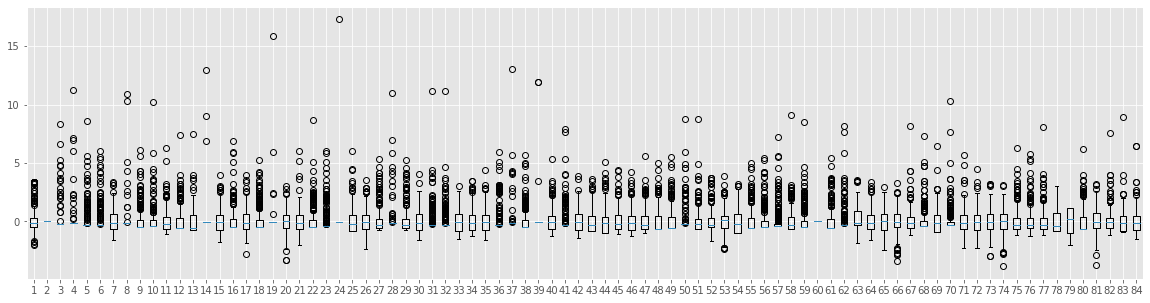

In [67]:
scaler = preprocessing.StandardScaler().fit(style_ds)
style_ds = scaler.transform(style_ds)
plt.figure(figsize=(20,5))
plt.boxplot(style_ds);

### Poems generated with GTP-J

In [20]:
# df_fake = extract_text(os.path.join(path_data, "fake_input.txt"))
df_fake = pd.read_csv(os.path.join(path_data, "PoetryData_fake.csv"))
df_fake = df_fake.sort_values(by="Poet")
df_fake.columns

Index(['Poet', 'Poem', 'Title'], dtype='object')

In [21]:
df_fake = df_fake.dropna()
df_fake = df_fake.drop_duplicates(subset=['Title'], ignore_index=True)
df_fake.to_csv(os.path.join(path_data, "PoetryData_fake.csv"),index=False)
df_fake.groupby(['Poet'])['Title'].count().nlargest(11)

Poet
Christina Rossetti     10
E. E. Cummings         10
Emily Dickinson        10
John Keats             10
Langston Hughes        10
Naomi Shihab Nye       10
Robert Frost           10
W. B. Yeats            10
Walt Whitman           10
William Shakespeare    10
Name: Title, dtype: int64

In [22]:
# cleaning
df_fake.loc[:, "Poem"] = df_fake.loc[:, "Poem"].str.replace("\r","")
df_fake.loc[:, "Poem"] = df_fake.loc[:, "Poem"].str.rstrip("\n")

df_fake.loc[:, "Title"] = df_fake.loc[:, "Title"].str.replace(r" {2,}", "", regex=True)
df_fake.loc[:, "Title"] = df_fake.loc[:, "Title"].str.replace("\n", "")
df_fake.loc[:, "Title"] = df_fake.loc[:, "Title"].str.replace("\r", "")

df_fake.loc[:, "Poet"] = df_fake.loc[:, "Poet"].str.replace("\n", "")
df_fake.loc[:, "Poet"] = df_fake.loc[:, "Poet"].str.replace("\r", "")

nan_poems = df_fake["Poem"].isnull().sum()
nan_poets = df_fake["Poet"].isnull().sum()
nan_title = df_fake["Title"].isnull().sum()
print(f"Num NaN Poems: {nan_poems}" +
      f"\nNum NaN Poets: {nan_poets}" +
      f"\nNum NaN Title: {nan_title}")

Num NaN Poems: 0
Num NaN Poets: 0
Num NaN Title: 0


In [23]:
"""
Poem text files should be formatted as:
TITLE
AUTHOR
TEXTTEXTTEXT[...]
******
TITLE2
AUTHOR(2)
TEXT...
"""

with open(os.path.join(path_data, "fake_input.txt"), "w", encoding='UTF-8') as f:
    aux = ""
    for _, row in df_fake.iterrows():
        new_line = str(row["Title"]) + "\n" + str(row["Poet"]) + "\n" + str(row["Poem"]) + "\n******\n"
        
        f.write(new_line)

In [6]:
#Open output file, remove first file and also the separators
with open(os.path.join(path_data, "fake_out.txt"), "r", encoding='UTF-8', errors='ignore') as f :
    fake_output = f.readlines()
fake_output = fake_output[1:]
fake_output = list(filter(lambda a: "***" not in a, fake_output))

#Split for each line and store in a list (probably useless but idc)
fake_out_list = []
for elem in fake_output :
    content = elem.split("|")[2:]
    #remove \n of last e
    content[-1] = content[-1][:-1]
    
    fake_out_list.append(content)

style_fake_ds = np.array(fake_out_list, dtype=np.float64)

with open(os.path.join(path_data, "fake_out.npy"), 'wb') as f:
    np.save(f, style_fake_ds)

In [70]:
with open(os.path.join(path_data, "fake_out.npy"), 'rb') as f:
    style_fake_ds = np.load(f)

style_fake_ds.shape

(100, 84)

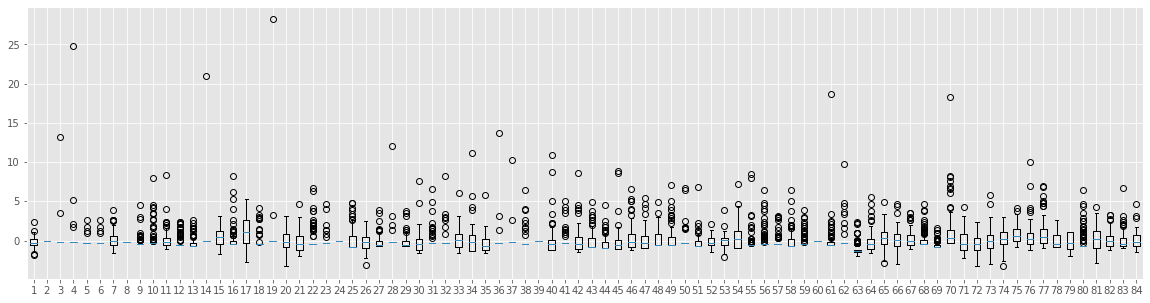

In [71]:
style_fake_ds = scaler.transform(style_fake_ds)
plt.figure(figsize=(20,5))
plt.boxplot(style_fake_ds);

### Creation of the points clouds 

In [39]:
#Calcul des distances 
d=spatial.distance.pdist(style_ds_train, "euclidean")
distance = sr.Distance(d)
matrix_distance=distance.square_form()
nb_poems=len(style_ds_train)

(array([[  1.,  19.,  84., ...,   0.,   0.,   0.],
        [  1.,  10.,  74., ...,   0.,   0.,   0.],
        [  1.,  17., 132., ...,   1.,   0.,   0.],
        ...,
        [  2.,  66.,  63., ...,   1.,   0.,   0.],
        [  2.,  59.,  68., ...,   0.,   0.,   0.],
        [  4.,  60.,  64., ...,   1.,   0.,   0.]]),
 array([0.        , 0.2325774 , 0.46515481, 0.69773221, 0.93030962,
        1.16288702, 1.39546443, 1.62804183, 1.86061924, 2.09319664,
        2.32577405]),
 <a list of 250 BarContainer objects>)

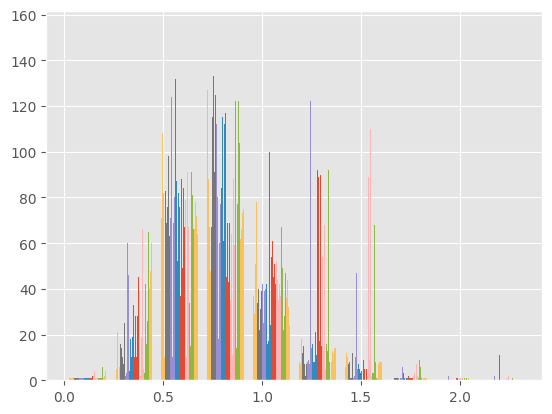

In [40]:
plt.hist(matrix_distance)

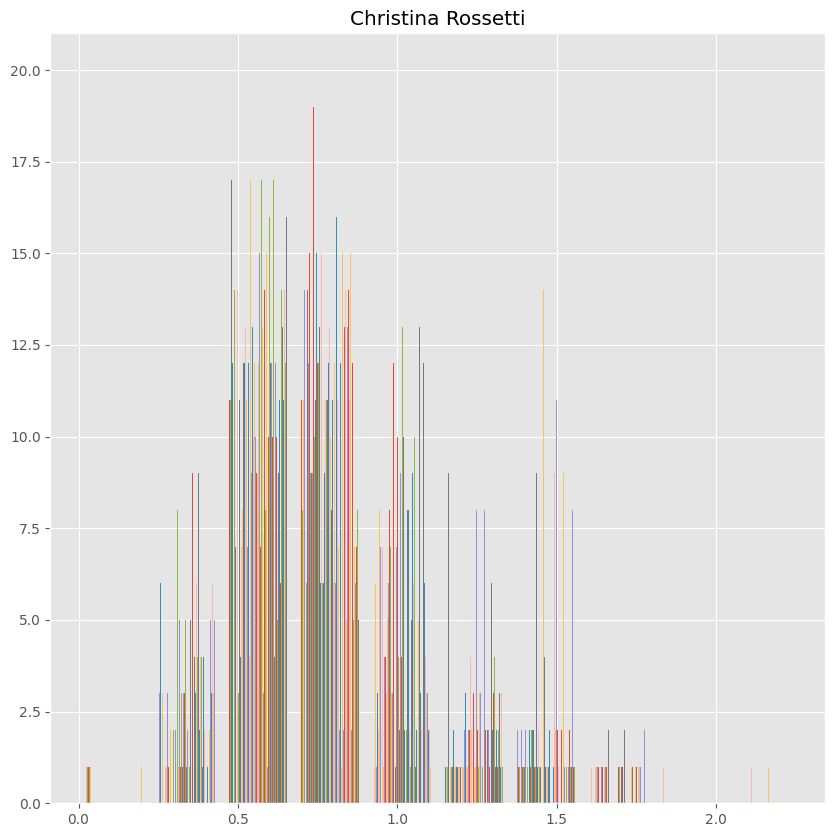

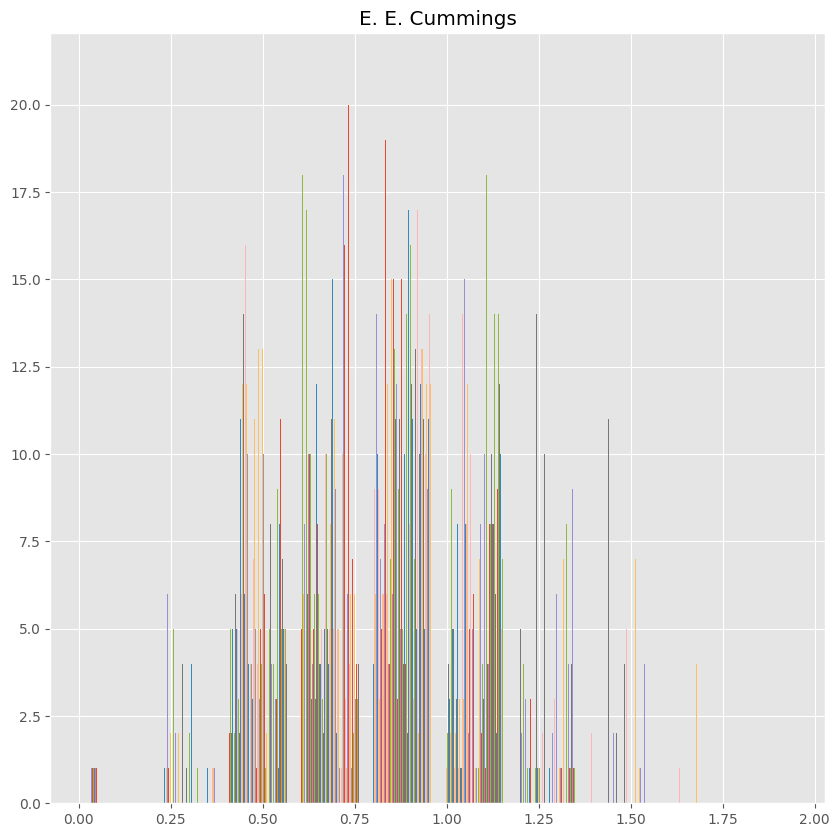

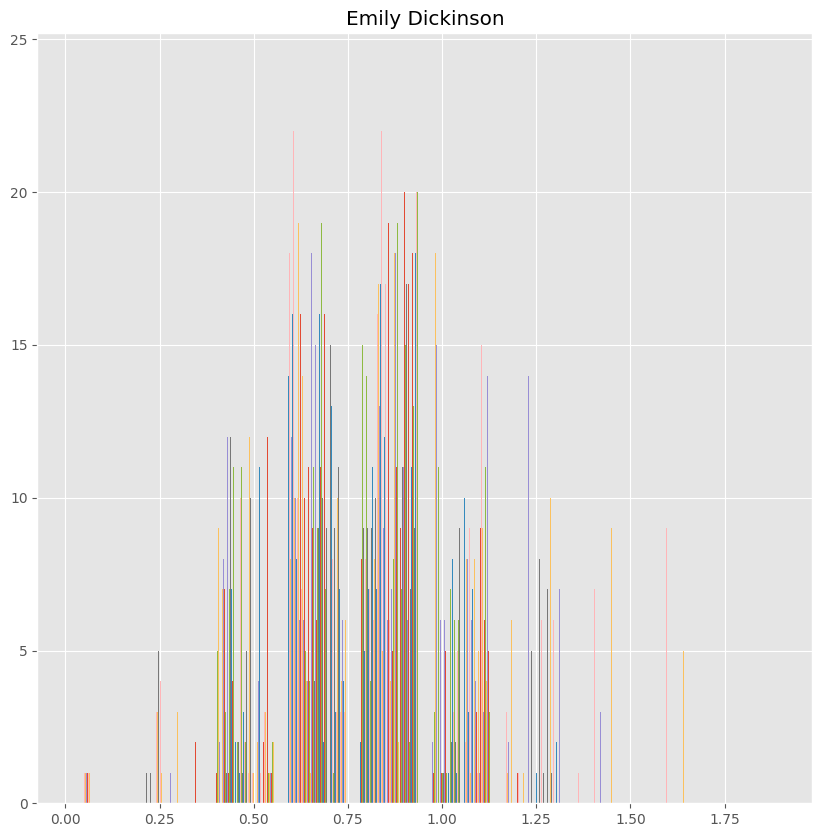

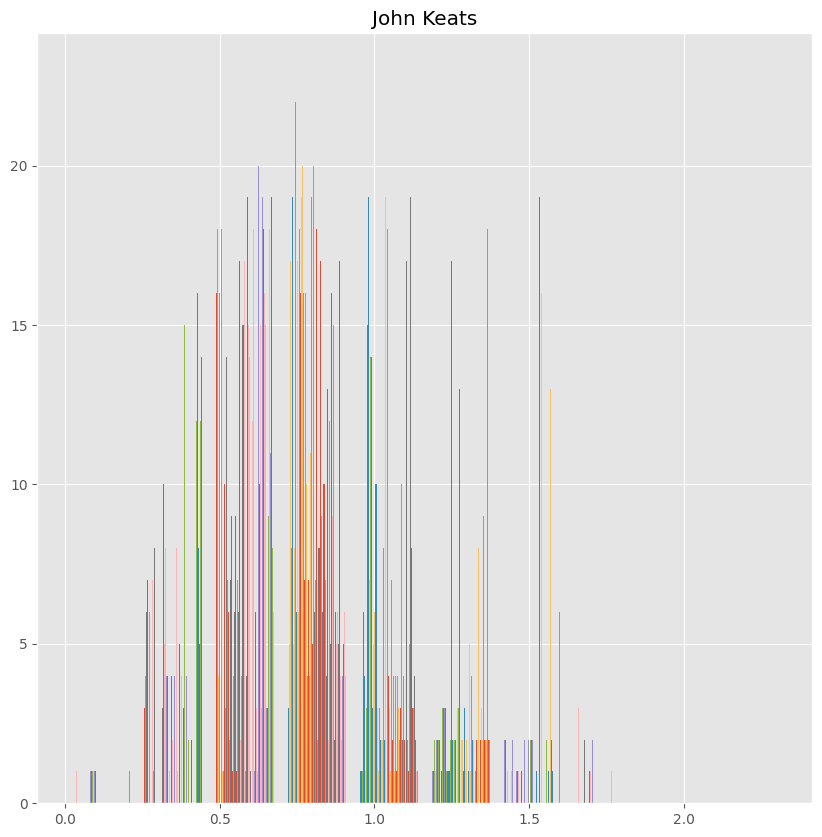

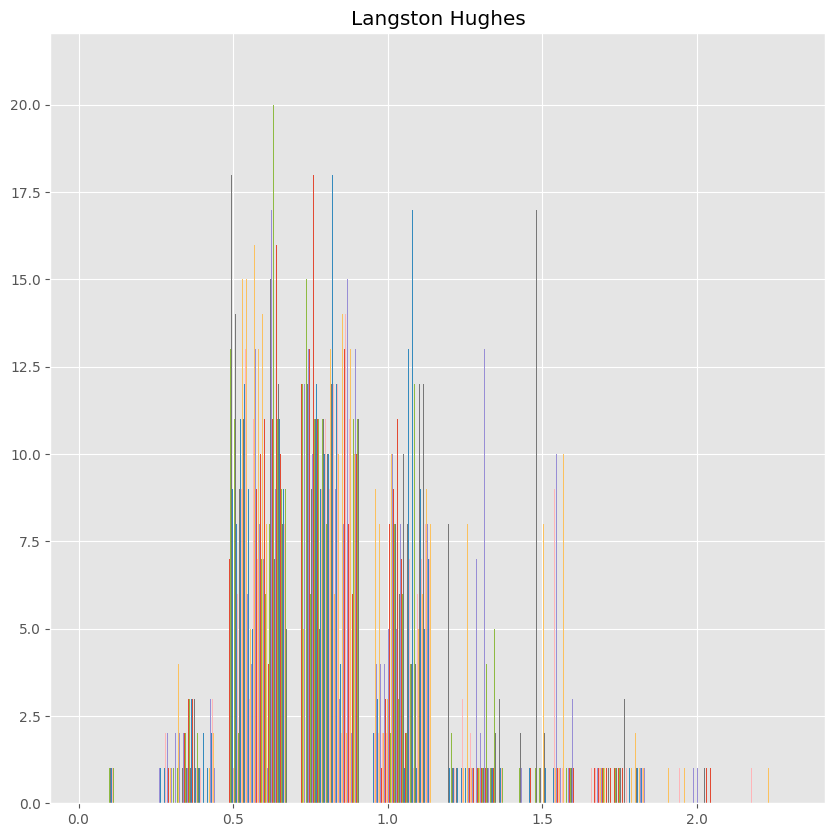

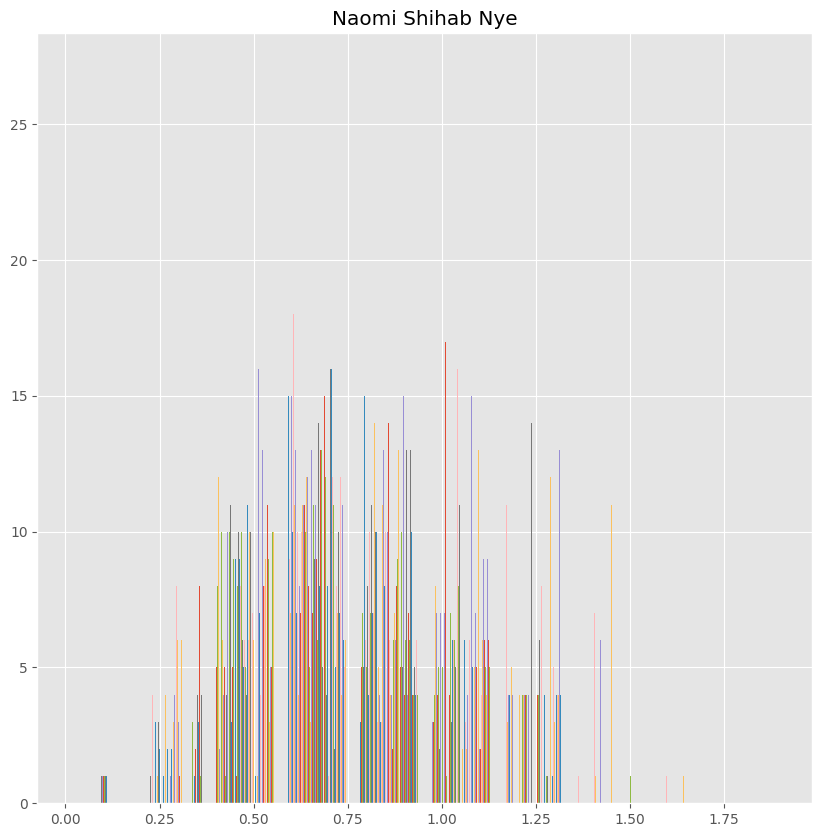

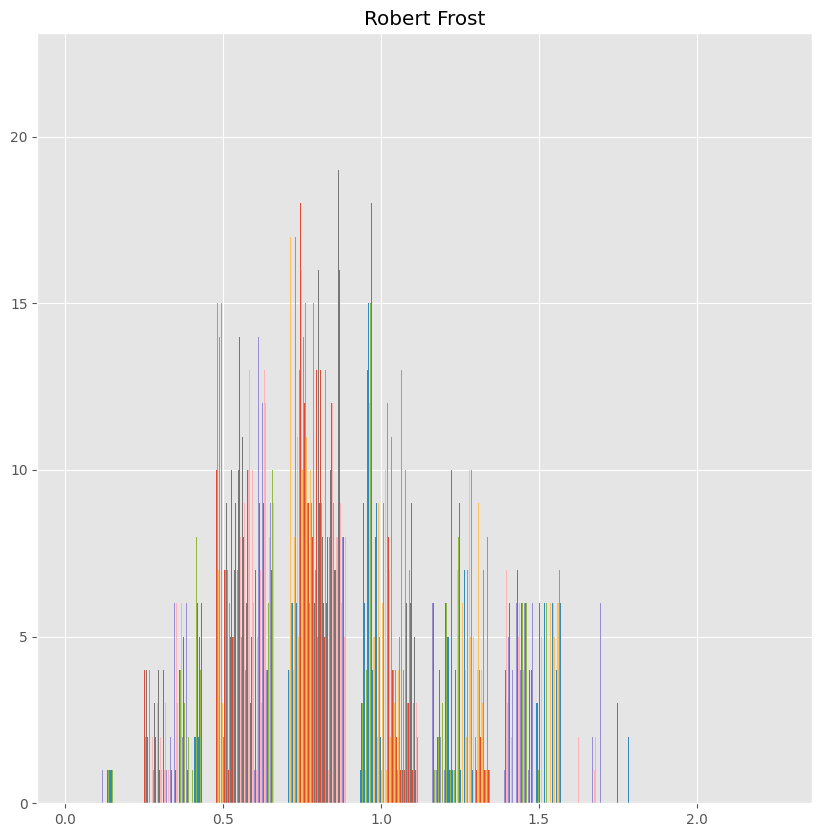

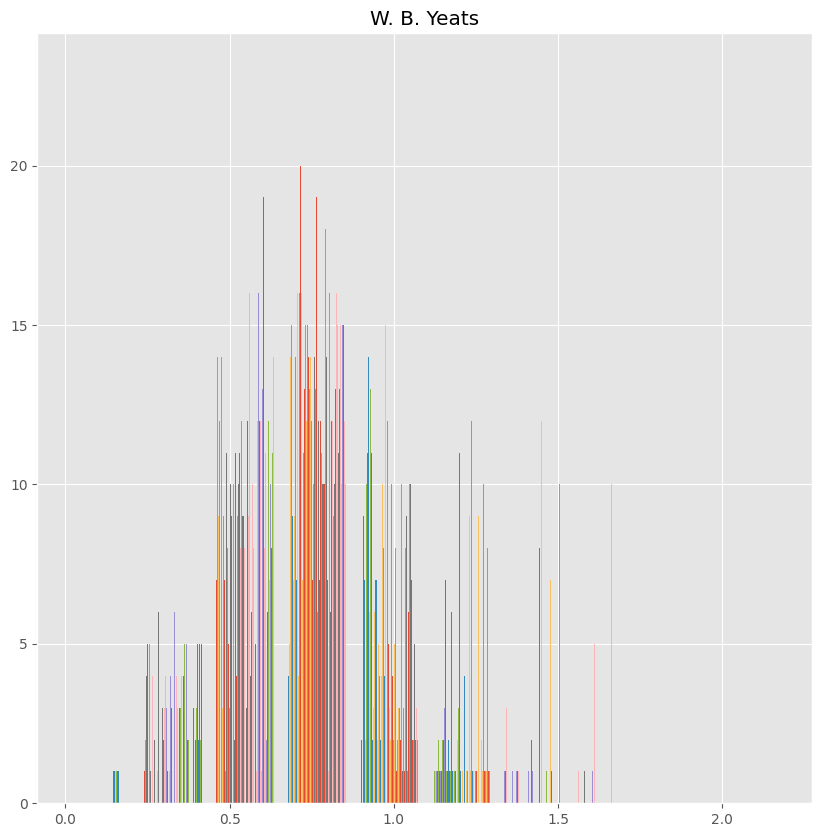

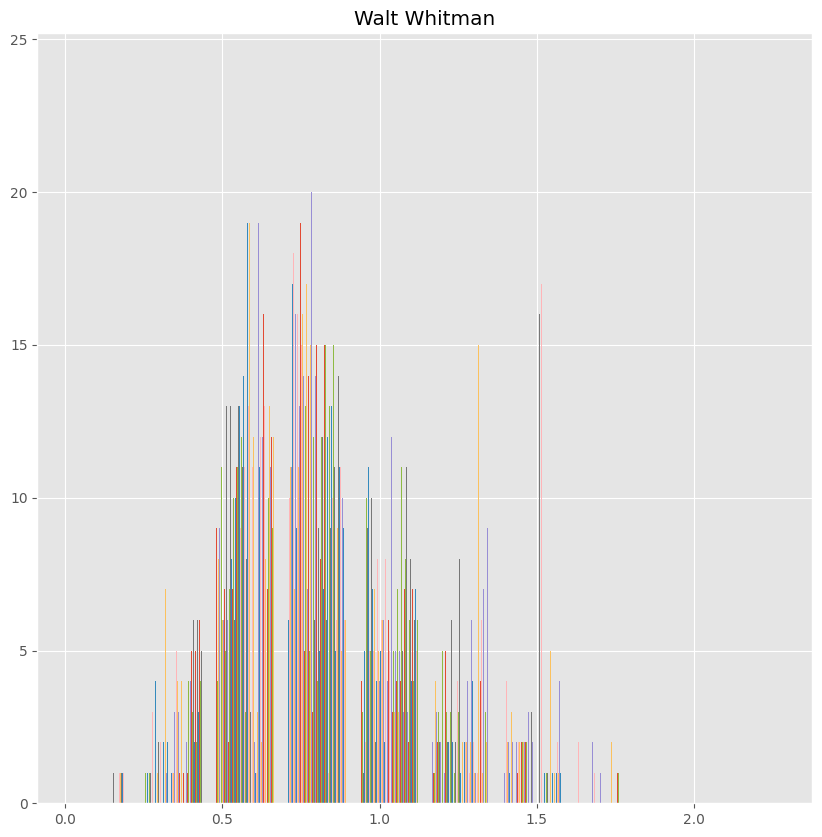

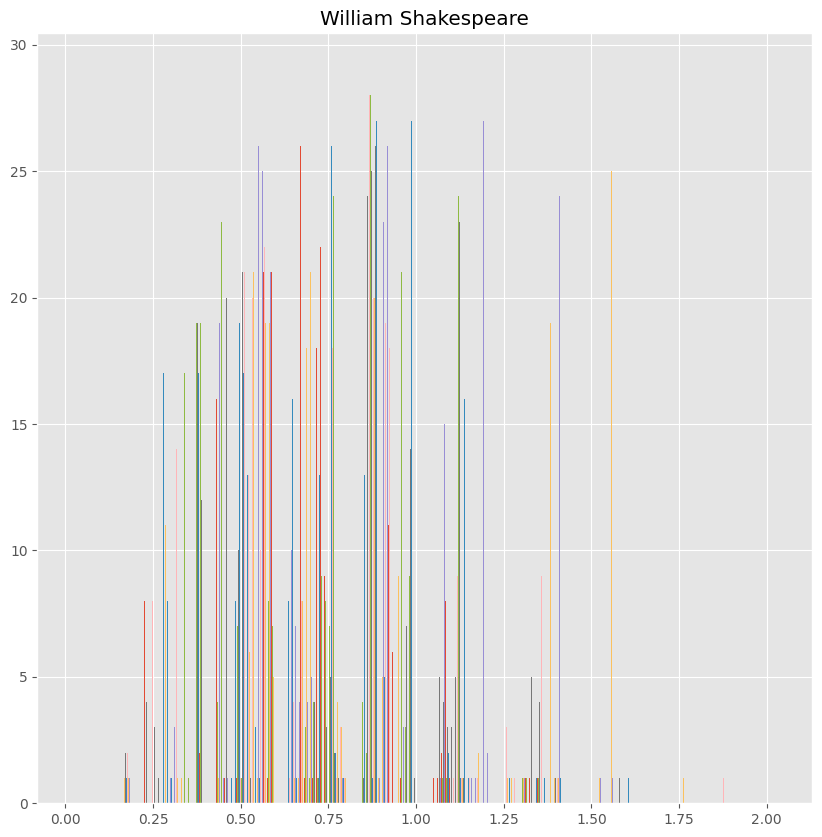

In [11]:
#histogram by author 
for i, txt in enumerate(list_author): 
    fig= plt.figure(i, figsize=(10,10))
    plt.hist(matrix_distance[30*i:30*(i+1),:])
    plt.title(txt)


In [12]:
distributions = {}
distributions["0_0.5"] = sr.get_distribution(name="uniform", interval=[0,0.5])
distributions["0.5_0.7"] = sr.get_distribution(name="uniform", interval=[0.5,0.7])
distributions["0.7_0.95"] = sr.get_distribution(name="uniform", interval=[0.7,0.95])
distributions["0.95_1.2"] = sr.get_distribution(name="uniform", interval=[0.95,1.2])
distributions["1.2_2.0"] = sr.get_distribution(name="uniform", interval=[1.2,2.0])

In [13]:
probabilities = {}
for k in distributions.keys():
    probabilities[k] = distributions[k](matrix_distance)

number_instances=100
sample_size=10

   
h0_sr = {}
h1_sr = {}
for k in  distributions.keys():
    h0_sr[k] = []
    h1_sr[k] = []
    for poem in matrix_distance:
        p = distributions[k](poem)
        s = sr.get_sample(number_instances, sample_size, p)
        f = distance.get_h0sr(sample=s,clustering_method="complete")
        b = distance.get_bc(sample=s, maxdim=1)
        g = sr.bc_to_sr(b,degree="H1")
        h0_sr[k].append(f)
        h1_sr[k].append(g)  


### Analysis of the point clouds

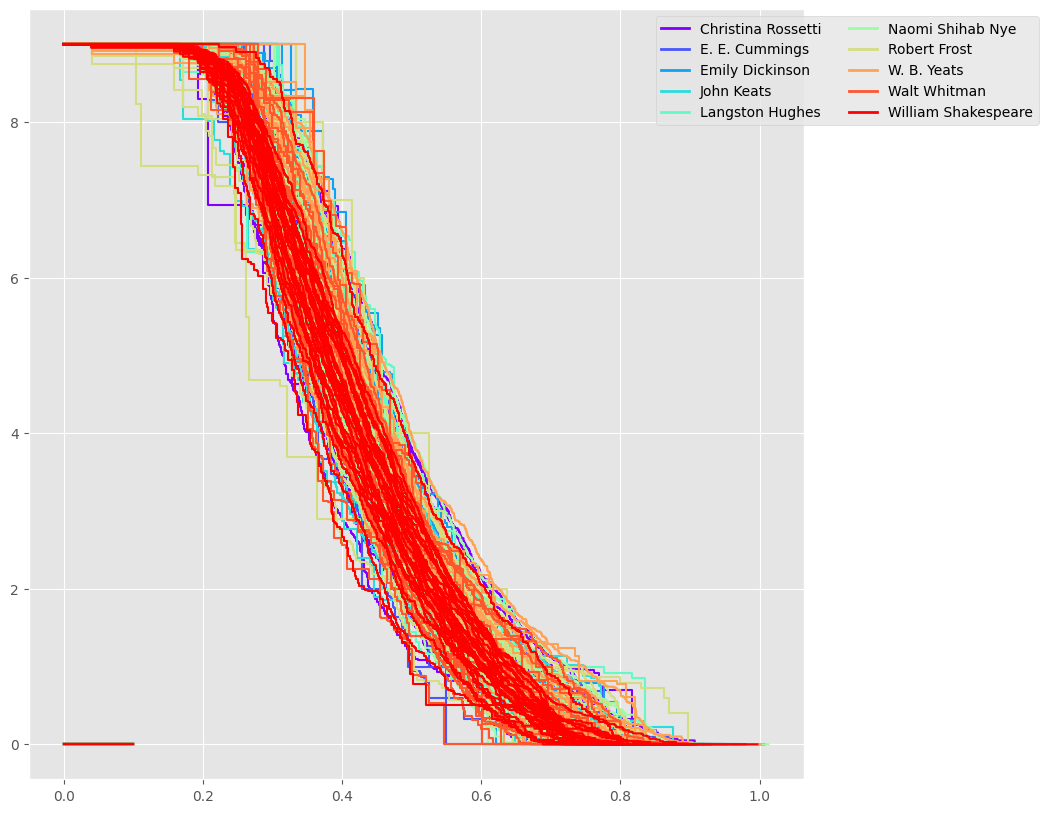

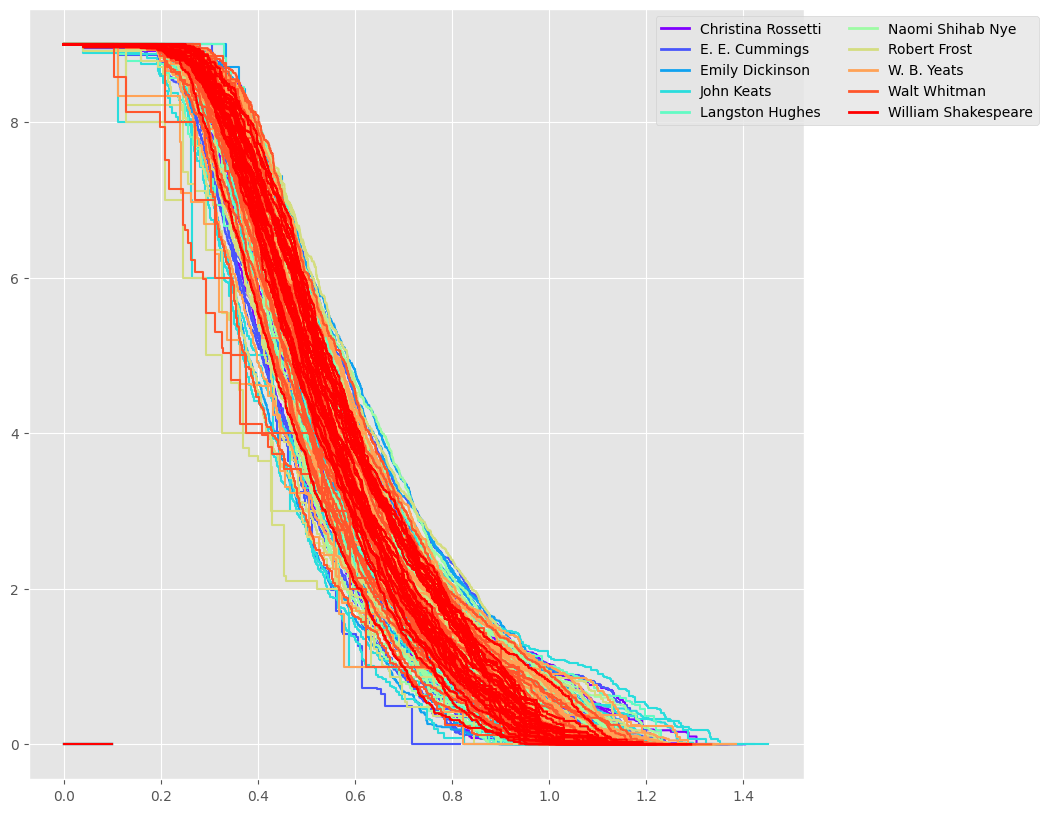

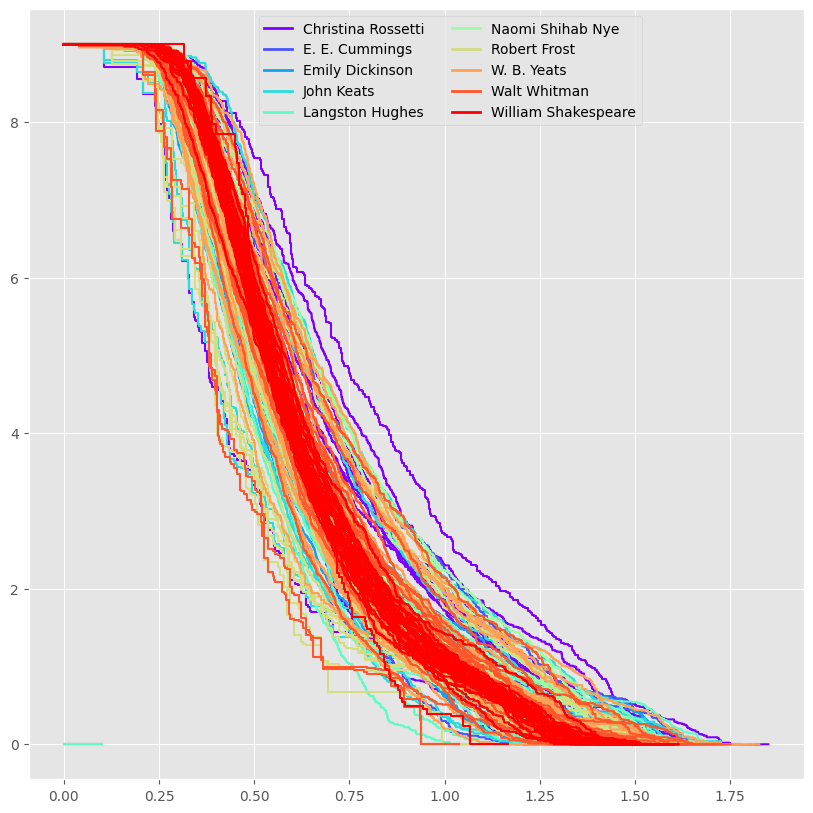

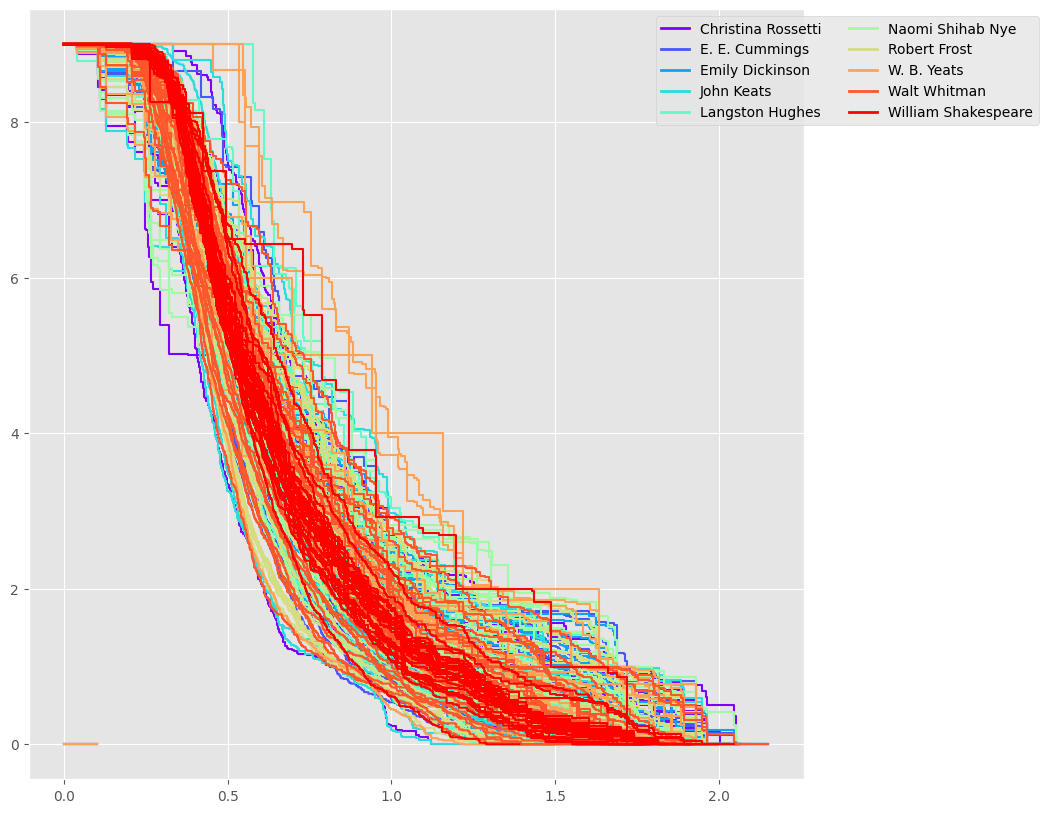

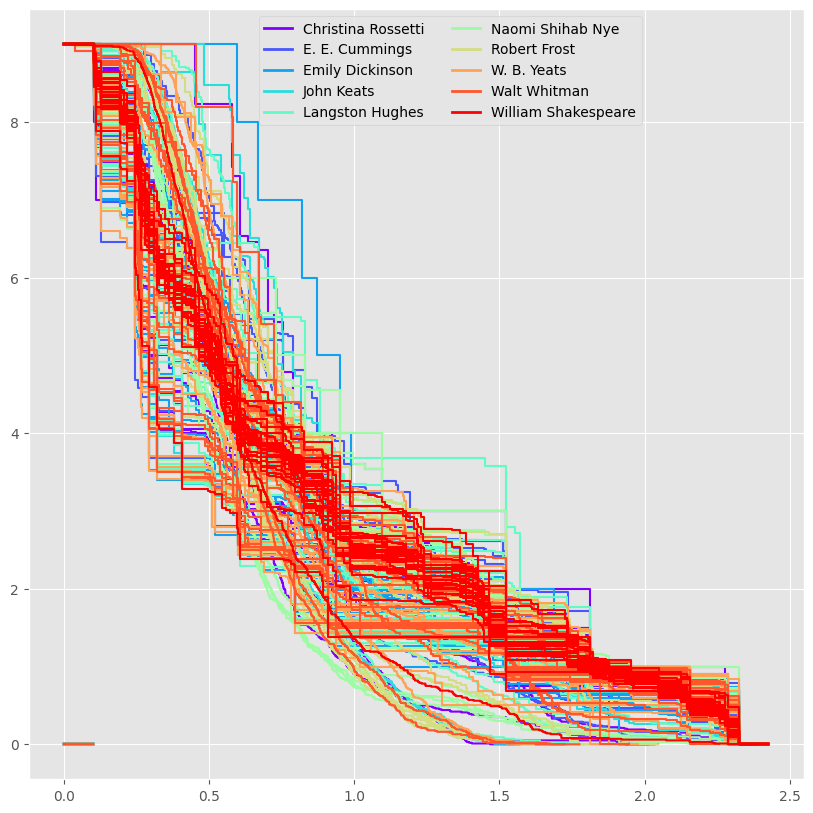

In [19]:
#h0 plot one color by author 

list_integers = range(0,10) #the range and variance of this list will vary 
cmap=cm.rainbow(np.array(list_integers)/(2*np.mean(list_integers)))
custom_lines = [Line2D([0], [0], color=cmap[i], lw=2) for i in range(10)]


for k in distributions.keys():
    fig= plt.figure(k,figsize=(10,10))
    i = 0
    color= -1
    for f in h0_sr[k]:
        if i % 30 ==0 :
            color+= 1
        f.plot(color = cmap[color])
        plt.legend(custom_lines, [s for s in list_author], ncol=2,bbox_to_anchor=(0.8, 1.0))

        i += 1



In [ ]:
#h0 plot one color by author 

cmap=cm.rainbow(np.array(list_integers)/(2*np.mean(list_integers)))
custom_lines = [Line2D([0], [0], color=cmap[i], lw=2) for i in range(10)]


for k in distributions.keys():
    fig= plt.figure(k,figsize=(10,10))
    i = 0
    color= -1
    for f in h0_sr[k]:
        if i % 30 ==0 :
            color+= 1
        f.plot(color = cmap[color])
        plt.legend(custom_lines, [s for s in list_author], ncol=2,bbox_to_anchor=(0.8, 1.0))

        i += 1

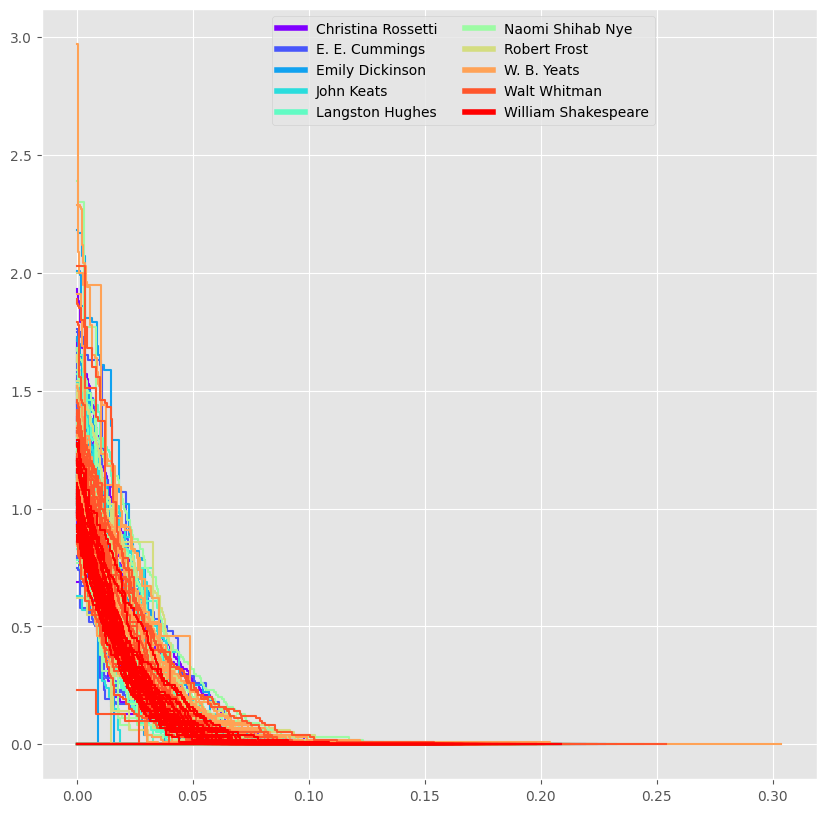

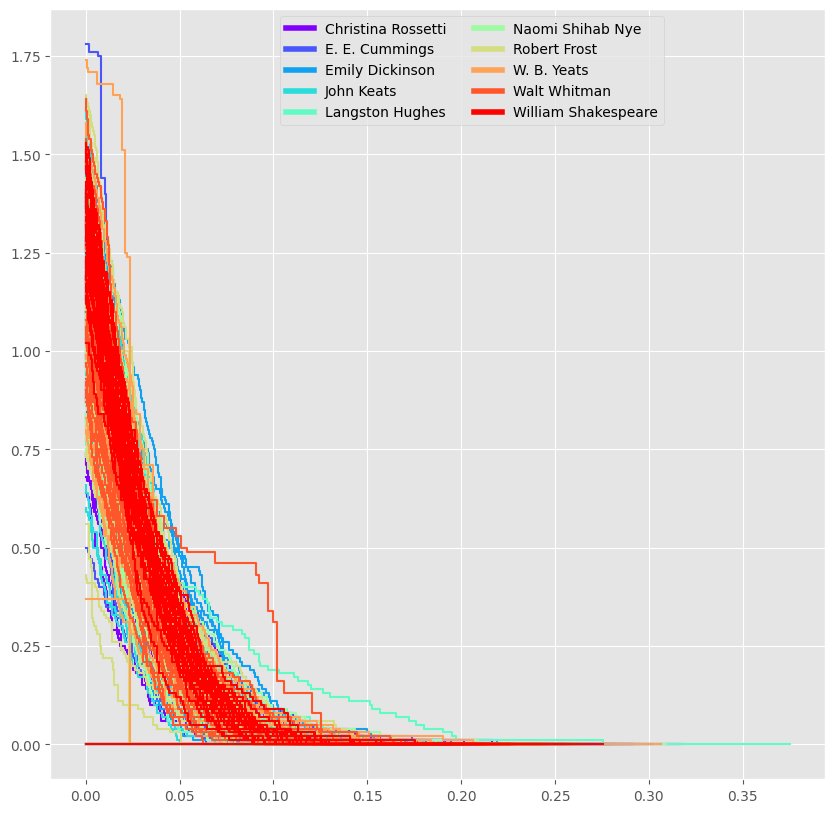

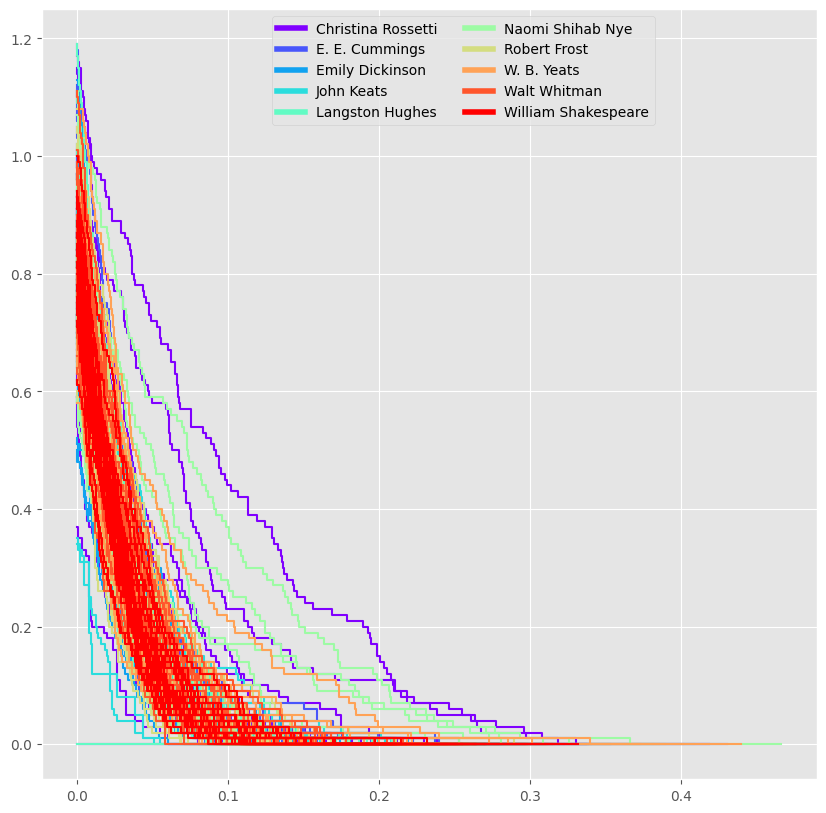

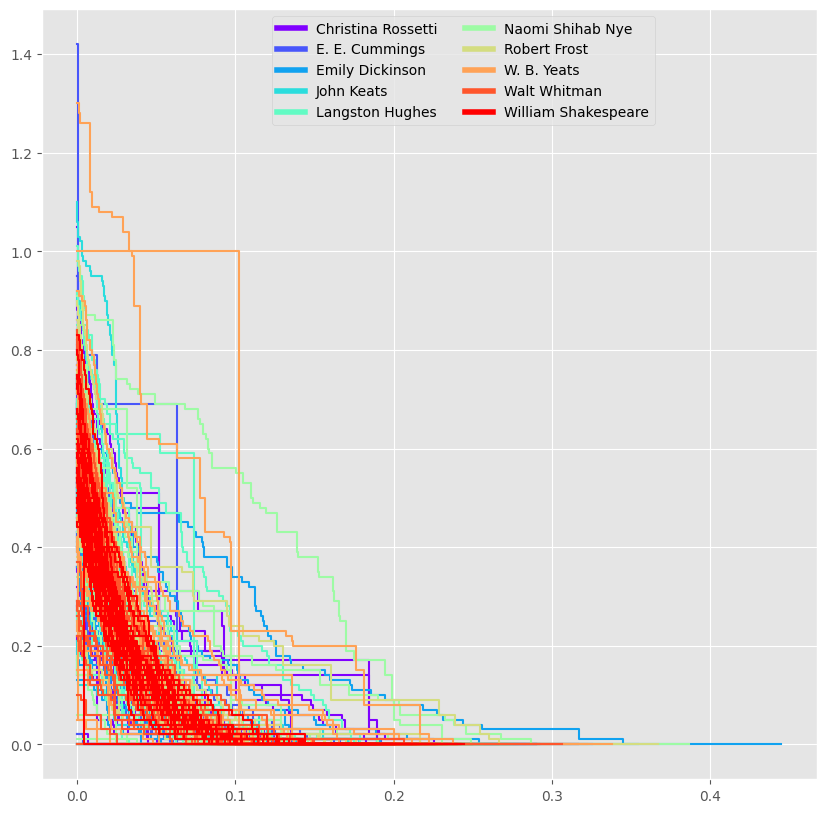

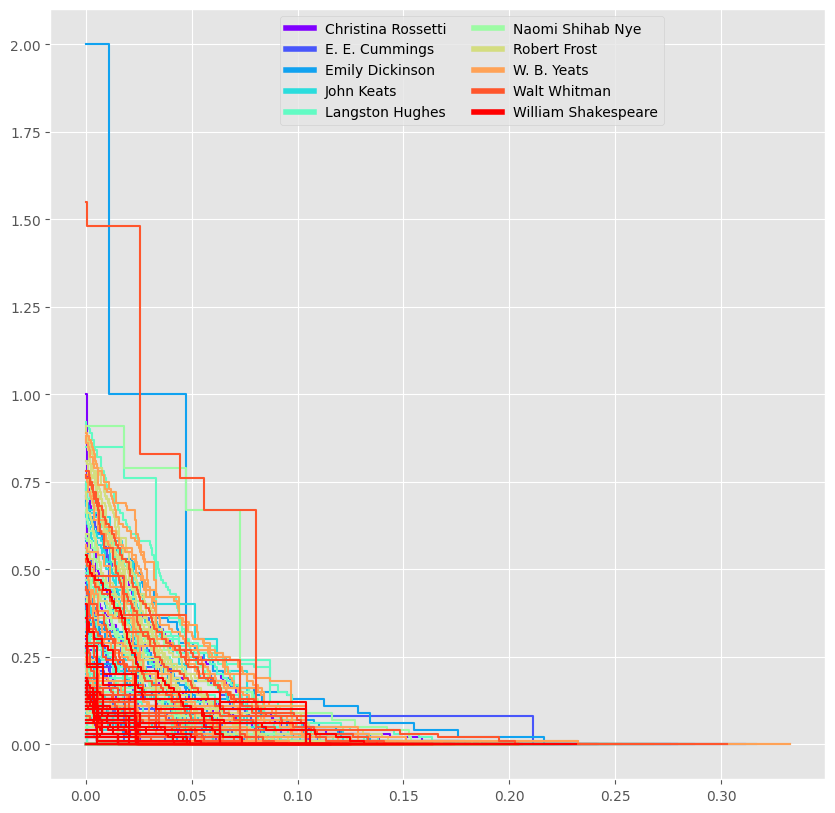

In [18]:
#h1 plot

list_integers = range(0,10) #the range and variance of this list will vary 
cmap=cm.rainbow(np.array(list_integers)/(2*np.mean(list_integers)))
custom_lines = [Line2D([0], [0], color=cmap[i], lw=4) for i in range(10)]


for k in distributions.keys():
    fig= plt.figure(k,figsize=(10,10))
    i = 0
    color= -1
    for f in h1_sr[k]:
        if i % 30 ==0 :
            color+= 1
        f.plot(color = cmap[color])
        plt.legend(custom_lines, [s for s in list_author], ncol=2,bbox_to_anchor=(0.8, 1.0))

        i += 1


## Semantic classification

### Bert embeddings

In [36]:
# Creation in pipeline_from_csv_to_bert.ipynb
# Extraction from save file
sem_ds = []
with open(os.path.join(path_data, "bert.npy"), 'rb') as f:
    for _ in range (300):
        sem_ds.append(np.load(f).T)

with open(os.path.join(path_data, "tokens.p"), "rb") as f:
    tokens =  pickle.load(f)

print("-"*10 + "True poems" + "-"*10)
print("Num poems:", len(sem_ds))
print("Dimension:", sem_ds[0].shape[1])
num_tokens = [p.shape[0] for p in sem_ds]

fake_sem_ds = []
with open(os.path.join(path_data, "fake_bert.npy"), 'rb') as f:
     for _ in range (100):
        fake_sem_ds.append(np.load(f).T)

with open(os.path.join(path_data, "fake_tokens.p"), "rb") as f:
    fake_tokens =  pickle.load(f)


print("\n" + "-"*10 + "Fake poems" + "-"*10)
print("Num poems:", len(fake_sem_ds))
print("Dimension:", fake_sem_ds[0].shape[1])
num_tokens_fake = [p.shape[0] for p in fake_sem_ds]

----------True poems----------
Num poems: 300
Dimension: 1024

----------Fake poems----------
Num poems: 100
Dimension: 1024


c:\Users\alexg\anaconda3\envs\ml_env\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


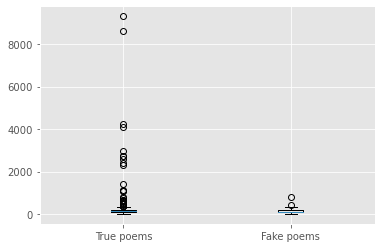

In [37]:
plt.boxplot([num_tokens, num_tokens_fake], showfliers=True, labels=["True poems", "Fake poems"]);

c:\Users\alexg\anaconda3\envs\ml_env\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


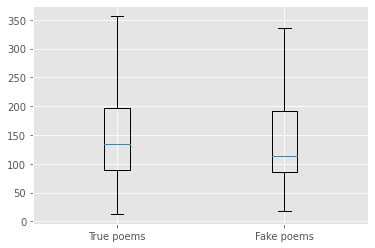

In [38]:
plt.boxplot([num_tokens, num_tokens_fake], showfliers=False, labels=["True poems", "Fake poems"]);

In [119]:
num_poem = 97
emb_poem_test = sem_ds[num_poem]
token_poem_test = tokens[num_poem]
poem_title_test = " - ".join(df.loc[num_poem, ["Poet", "Title"]].values)
print(poem_title_test)
emb_poem_test.shape

William Shakespeare - Hamlet, Act III, Scene I [To be, or not to be]


(339, 1024)

In [120]:
pca = PCA(n_components = 50, random_state = 7)
emb_poem_test = pca.fit_transform(emb_poem_test)
tsne = TSNE(n_components = 2, perplexity = 10, learning_rate="auto", init="pca")
emb_poem_test = tsne.fit_transform(emb_poem_test)
emb_poem_test.shape

c:\Users\alexg\anaconda3\envs\ml_env\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


(339, 2)

134

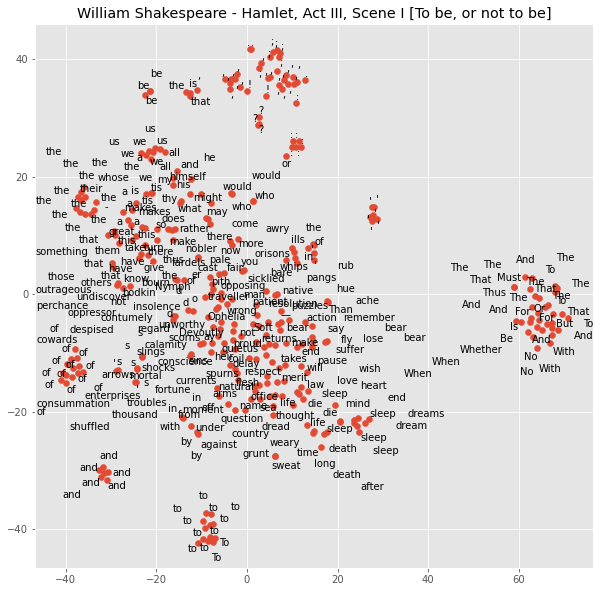

In [121]:
plt.figure(figsize=(10,10))
plt.scatter(emb_poem_test[:, 0], emb_poem_test[:, 1])

texts = [plt.text(emb_poem_test[i, 0], emb_poem_test[i, 1], txt, ha='center', va='center')
         for i, txt in enumerate(token_poem_test)]
plt.title(poem_title_test)
adjust_text(texts)

## Full info classification

In [122]:
mean_sem = np.array([poem.mean(axis=0) for poem in sem_ds])
full_ds = np.hstack([style_ds, mean_sem])
print(full_ds.shape)

with open(os.path.join(path_data, "full_save.npy"), 'wb') as f:
    np.save(f, full_ds)


mean_fake_sem = np.array([poem.mean(axis=0) for poem in fake_sem_ds])
full_fake_ds = np.hstack([style_fake_ds, mean_fake_sem])
print(full_fake_ds.shape)

with open(os.path.join(path_data, "full_fake_save.npy"), 'wb') as f:
    np.save(f, full_fake_ds)


(300, 1108)
(100, 1108)


In [123]:
with open(os.path.join(path_data, "full_save.npy"), 'rb') as f:
    full_ds = np.load(f)

with open(os.path.join(path_data, "full_fake_save.npy"), 'rb') as f:
    full_fake_ds = np.load(f)